In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Annotated Data

In [74]:
data_filename  = '../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_b = load_cf_labels(data_filename)
d_b = tidy_labels(d_b)

data_filename  = '../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_r = load_cf_labels(data_filename)
d_r = tidy_labels(d_r)

In [75]:
l_b = plurality(d_b['attack'].dropna())
l_r = plurality(d_r['attack'].dropna())

In [76]:
data_b = get_labeled_comments(d_b, l_b)
data_r = get_labeled_comments(d_r, l_r)

### NGram Classification Pipeline

In [58]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LinearSVC()),
])

In [59]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C': (0.001, 0.1, 1.0)
}

In [77]:
train, test = split(data_b)
model = tune (train['x'], train['y'], cv_pipeline, param_grid, 'roc_auc', n_jobs=8, verbose=True)
evaluate(model, test, roc_auc, plot = False)


Best parameters set found:
{'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__C': 1.0} 0.862969412279


Grid scores:
0.72033 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__C': 0.001}
0.71334 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__C': 0.001}
0.84909 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__C': 0.1}
0.85173 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__C': 0.1}
0.86297 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 6), 'vect__max_features': None, 'clf__C': 1.0}
0.86274 (+/-0.00000) for {'vect__analyzer': 'char', 'vect__ngram_range': (1, 5), 'vect__max_features': None, 'clf__C': 1.0}


0.85981407024013146

In [61]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LinearSVC(C = 1.0)),
])

### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [78]:
ms, metrics = eval_adding_other_data(optimal_pipeline, data_b, data_r, roc_auc)

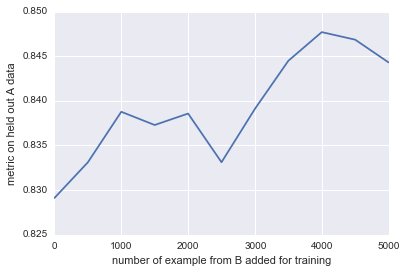

In [80]:
plot_adding_other_data(ms, metrics)

# Final Model

In [81]:
data = pd.concat([data_r,data_b])
model = optimal_pipeline.fit(data['x'], data['y'])
joblib.dump(model, '../models/attack_ngram.pkl')

['../models/attack_ngram.pkl',
 '../models/attack_ngram.pkl_01.npy',
 '../models/attack_ngram.pkl_02.npy',
 '../models/attack_ngram.pkl_03.npy',
 '../models/attack_ngram.pkl_04.npy',
 '../models/attack_ngram.pkl_05.npy']